In [1]:
import matplotlib
import sys
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.font_manager as fm
import gseapy as gp

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from cmapPy.pandasGEXpress.parse import parse
from scipy import stats
from pandas import DataFrame as df
from matplotlib import pyplot as plt
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# global path

In [2]:
data_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/data/'
gsea_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/GSEA/'
panel_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/panels/Figure1/'
auc_home = panel_home + 'auc/'

# Data

In [3]:
# L1000 gene info
bing_landmark = pd.read_csv(data_home + 'CMAP2020_Cancer/landmark_and_bings_L1000.csv',
                            header=0, index_col=0, sep=',', dtype={'Official NCBI gene symbol': 'str'}, converters={'Official NCBI gene symbol': None})
bing_landmark

,Official NCBI gene symbol
Official NCBI gene id,
5720,PSME1
7416,VDAC1
55847,CISD1
10174,SORBS3
25803,SPDEF
...,...
5137,PDE1C
51233,DRICH1
4340,MOG


In [4]:
gene_sets = {}
with open(gsea_home + '/gene_sets/NREC_REC_91061.gmt', 'r') as f:
    for lines in f:
        lines = lines.rstrip().split('\t')
        gene_sets[lines[0]] = lines[2:]
print(gene_sets.keys())

dict_keys(['NREC_profile', 'REC_profile'])


In [5]:
# read GSE93157 info
info_93157 = pd.read_csv(data_home + '/GSE93157/GSE93157_info.txt',
                         index_col=0, header=0, sep='\t').T
info_93157

Sample_title,Sample_geo_accession,Cancer_type,Age,prev_lines,BRAF_mut,NRAS_mut,EGFR_mut,ALK_stat,Biopsy,Smoking,ECOG,Gender,Treatment,Best_Response,Response,PFSE,PFS
Patient1,GSM2445676,HEADNECK,age: 75,prev. lines: 1,braf: NA,nras: NA,egfr: NA,alk: NA,biopsy: ARCHIVAL,smoking: FS,ecog: 0,Sex: M,drug: NIVOLUMAB,best.resp: SD,response: RC_RP_SD,pfse: 1,pfs: 2.73333333
Patient2,GSM2445677,HEADNECK,age: 72,prev. lines: 1,braf: NA,nras: NA,egfr: NA,alk: NA,biopsy: ARCHIVAL,smoking: FS,ecog: 1,Sex: M,drug: NIVOLUMAB,best.resp: PD,response: RC_RP_SD,pfse: 1,pfs: 2
Patient3,GSM2445678,HEADNECK,age: 57,prev. lines: 1,braf: NA,nras: NA,egfr: NA,alk: NA,biopsy: BASELINE,smoking: CS,ecog: 1,Sex: M,drug: NIVOLUMAB,best.resp: SD,response: RC_RP_SD,pfse: 0,pfs: 1.8
Patient4,GSM2445679,HEADNECK,age: 50,prev. lines: 1,braf: NA,nras: NA,egfr: NA,alk: NA,biopsy: BASELINE,smoking: FS,ecog: 1,Sex: M,drug: NIVOLUMAB,best.resp: CR,response: RC_RP_SD,pfse: 0,pfs: 13.5666667
Patient5,GSM2445680,HEADNECK,age: 59,prev. lines: 1,braf: NA,nras: NA,egfr: NA,alk: NA,biopsy: BASELINE,smoking: FS,ecog: 1,Sex: M,drug: NIVOLUMAB,best.resp: PR,response: RC_RP_SD,pfse: 0,pfs: 12.1666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Patient61,GSM2445736,MELANOMA,age: 55,prev. lines: 0,braf: WT,nras: NA,egfr: NA,alk: NA,biopsy: BASELINE,smoking: CS,ecog: 1,Sex: M,drug: PEMBROLIZUMAB,best.resp: PD,response: PD,pfse: 1,pfs: 1.7
Patient62,GSM2445737,MELANOMA,age: 41,prev. lines: 0,braf: MUT,nras: NA,egfr: NA,alk: NA,biopsy: BASELINE,smoking: CS,ecog: 0,Sex: M,drug: PEMBROLIZUMAB,best.resp: PR,response: RC_RP_SD,pfse: 0,pfs: 22.4333333
Patient63,GSM2445738,MELANOMA,age: 40,prev. lines: 2,braf: WT,nras: WT,egfr: NA,alk: NA,biopsy: BASELINE,smoking: CS,ecog: 0,Sex: M,drug: NIVOLUMAB,best.resp: PD,response: PD,pfse: 1,pfs: 4.43333333
Patient64,GSM2445739,MELANOMA,age: 62,prev. lines: 1,braf: WT,nras: NA,egfr: NA,alk: NA,biopsy: BASELINE,smoking: NS,ecog: 0,Sex: F,drug: PEMBROLIZUMAB,best.resp: PD,response: PD,pfse: 1,pfs: 3.16666667


In [6]:
info_93157['Cancer_type'].value_counts()

MELANOMA                    25
LUNG NON-SQUAMOUS CANCER    22
SQUAMOUS LUNG CANCER        13
HEADNECK                     5
Name: Cancer_type, dtype: int64

In [7]:
info_93157['Best_Response'].value_counts()

best.resp: PD    29
best.resp: PR    17
best.resp: SD    16
best.resp: CR     3
Name: Best_Response, dtype: int64

In [8]:
info_93157['Response'].value_counts()

response: RC_RP_SD    60
response: PD           5
Name: Response, dtype: int64

In [9]:
info_93157.columns

Index(['Sample_geo_accession', 'Cancer_type', 'Age', 'prev_lines', 'BRAF_mut',
       'NRAS_mut', 'EGFR_mut', 'ALK_stat', 'Biopsy', 'Smoking', 'ECOG',
       'Gender', 'Treatment', 'Best_Response', 'Response', 'PFSE', 'PFS'],
      dtype='object', name='Sample_title')

In [10]:
# add multiple color bars
label_cancer = info_93157['Cancer_type']
lut_cancer = dict(zip(set(label_cancer), sns.hls_palette(len(set(label_cancer)), l=0.5, s=0.8)))
cancer_colors = pd.DataFrame(label_cancer)['Cancer_type'].map(lut_cancer)

label_braf = info_93157['BRAF_mut']
lut_braf = dict(zip(set(label_braf), sns.hls_palette(len(set(label_braf)), l=0.5, s=0.8)))
braf_colors = pd.DataFrame(label_braf)['BRAF_mut'].map(lut_braf)

label_egfr = info_93157['EGFR_mut']
lut_egfr = dict(zip(set(label_egfr), sns.hls_palette(len(set(label_egfr)), l=0.5, s=0.8)))
egfr_colors = pd.DataFrame(label_egfr)['EGFR_mut'].map(lut_egfr)

label_biopsy = info_93157['Biopsy']
lut_biopsy = dict(zip(set(label_biopsy), sns.hls_palette(len(set(label_biopsy)), l=0.5, s=0.8)))
biopsy_colors = pd.DataFrame(label_biopsy)['Biopsy'].map(lut_biopsy)

label_treatment = info_93157['Treatment']
lut_treatment = dict(zip(set(label_treatment), sns.hls_palette(len(set(label_treatment)), l=0.5, s=0.8)))
treatment_colors = pd.DataFrame(label_treatment)['Treatment'].map(lut_treatment)

label_bresponse = info_93157['Best_Response']
lut_bresponse = dict(zip(['best.resp: CR', 'best.resp: PD', 'best.resp: PR', 'best.resp: SD'], ['royalblue', 'crimson', 'cornflowerblue', 'lightsteelblue']))
bresponse_colors = pd.DataFrame(label_bresponse)['Best_Response'].map(lut_bresponse)

In [11]:
paired_lut = {
    'cancer_type': {'color': cancer_colors, 'lut': lut_cancer},
    'braf_mut': {'color': braf_colors, 'lut': lut_braf},
    'egfr_mut': {'color': egfr_colors, 'lut': lut_egfr},
    'biopsy': {'color': biopsy_colors, 'lut': lut_biopsy},
    'treatment': {'color': treatment_colors, 'lut': lut_treatment},
    'best_response': {'color': bresponse_colors, 'lut': lut_bresponse},
}

In [12]:
set(label_bresponse)

{'best.resp: CR', 'best.resp: PD', 'best.resp: PR', 'best.resp: SD'}

In [13]:
# read expr
expr_93157 = pd.read_csv(data_home + '/GSE93157/GSE93157_expr.txt',
                         index_col=0, header=0, sep='\t')
expr_93157.shape

(766, 65)

In [14]:
expr_93157

,Patient1,Patient2,Patient3,Patient4,Patient5,Patient6,Patient7,Patient8,Patient9,Patient10,...,Patient56,Patient57,Patient58,Patient59,Patient60,Patient61,Patient62,Patient63,Patient64,Patient65
Sample_title,,,,,,,,,,,,,,,,,,,,,
A2M,11.904620,13.030058,8.193491,13.758953,11.558595,12.186479,13.554921,13.961349,13.169517,12.304875,...,13.236283,13.354265,13.067756,13.323437,12.983963,13.876389,12.316068,13.267003,12.584956,13.284093
ABCB1,5.361139,7.315529,6.386136,8.754496,4.907831,6.965299,6.858376,8.801500,7.140402,6.347495,...,7.683038,13.554708,5.114772,8.541388,6.507118,6.951127,6.573376,9.679764,7.268621,8.296150
ABCF1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABL1,9.696425,10.211099,8.556061,10.127871,9.721355,9.139977,9.568120,9.211688,9.140402,9.166099,...,10.040590,9.761677,9.365860,9.922817,9.442023,8.607118,9.287205,9.627184,9.647793,8.310577
ADA,8.048616,8.873712,8.244117,7.406140,6.978220,7.431208,6.246192,7.105893,7.840842,9.180038,...,8.142470,6.442041,8.330709,10.655404,8.106155,7.874401,7.297166,7.614529,6.963766,8.025848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZKSCAN5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZNF143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZNF205,6.534787,7.018263,7.193491,5.868874,6.848937,5.965299,7.204372,5.974649,5.840842,6.088408,...,6.570563,5.712688,6.557715,6.541388,6.994564,6.666084,6.757800,6.927532,6.830500,5.303382


# Expression stats

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


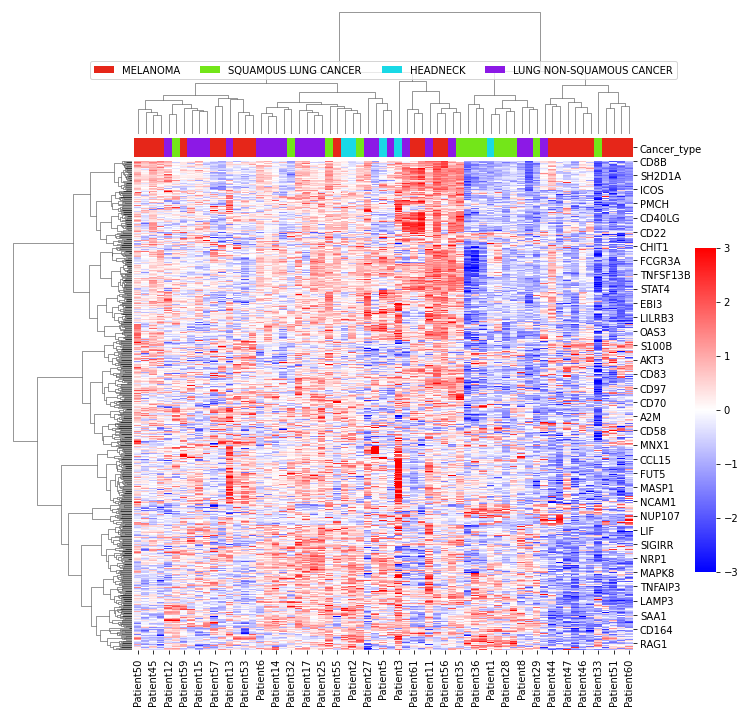

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


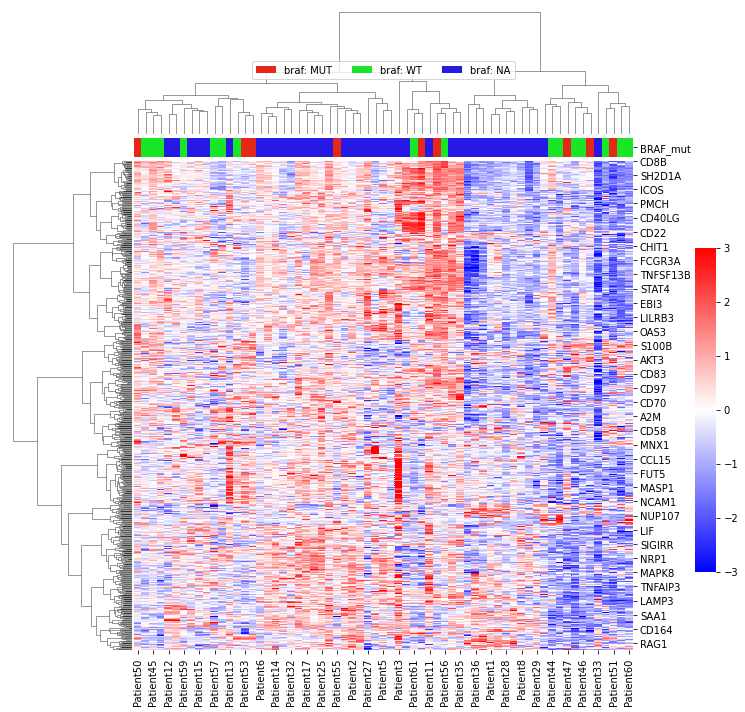

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


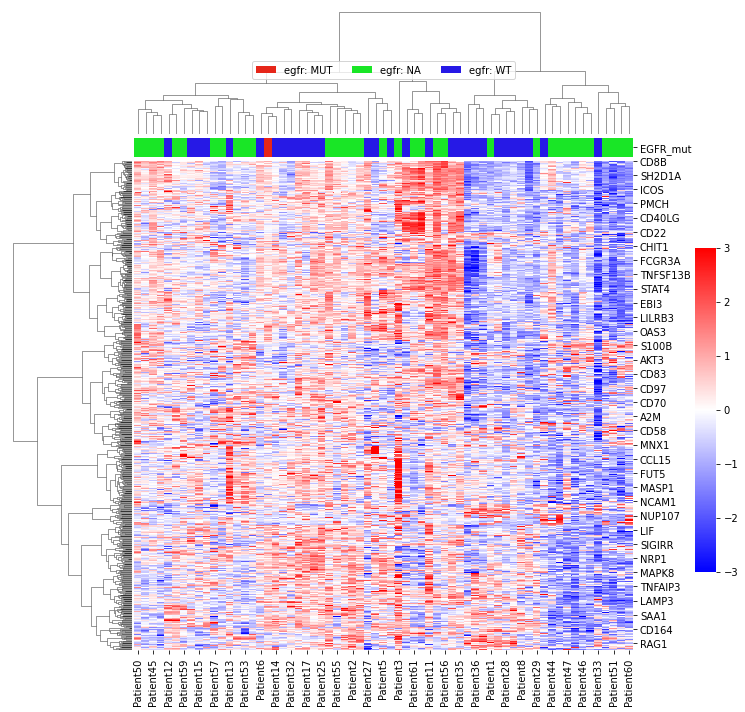

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


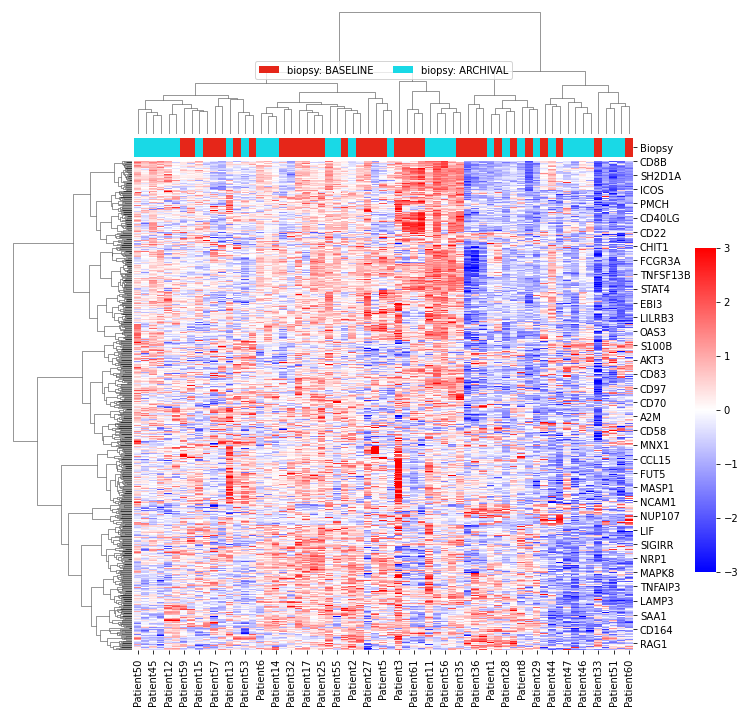

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


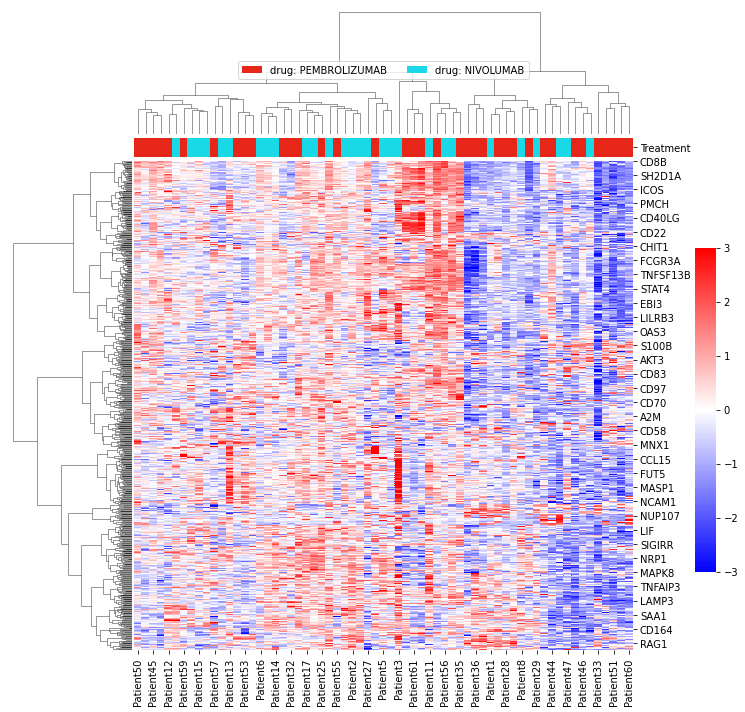

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


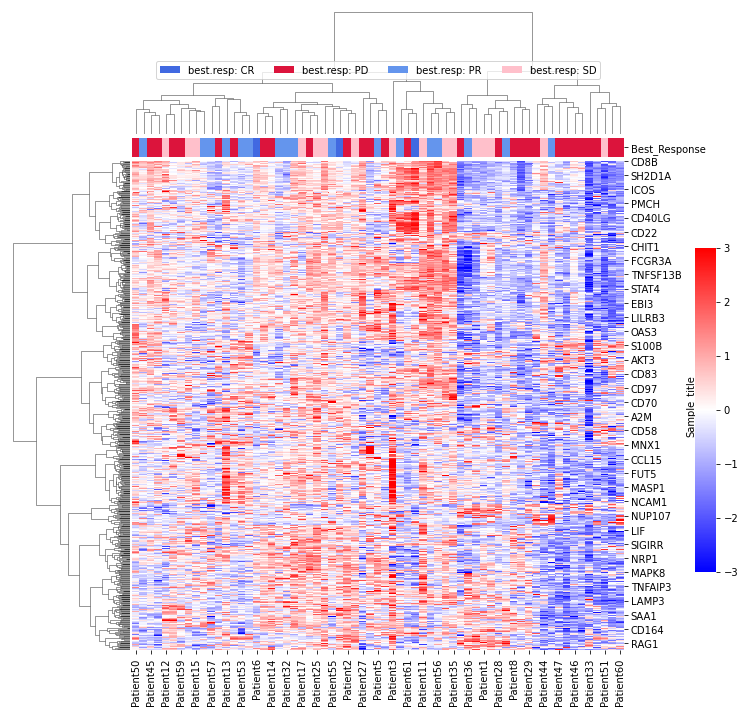

In [14]:
for c in paired_lut.keys():
    g = sns.clustermap(expr_93157[expr_93157 > 0].dropna(axis=0, how='all').fillna(0),
                   vmin=-3, vmax=3, z_score=0,
                   col_colors=paired_lut[c]['color'],
                   method='ward', cmap='bwr')
    for label in paired_lut[c]['lut'].keys():
        g.ax_col_dendrogram.bar(0, 0, color=paired_lut[c]['lut'][label],
                                label=label, linewidth=0)
        g.ax_col_dendrogram.legend(loc="center", ncol=5)

        # Adjust the postion of the main colorbar for the heatmap
        g.cax.set_position([.97, .2, .03, .45])
    plt.show()

# EC gene expressions

In [15]:
nrec_93157 = expr_93157[expr_93157.index.isin(gene_sets['NREC_profile'])]
nrec_93157.shape

(26, 65)

In [16]:
rec_93157 = expr_93157[expr_93157.index.isin(gene_sets['REC_profile'])]
rec_93157.shape

(32, 65)

In [17]:
ec_93157 = pd.concat([nrec_93157, rec_93157], axis=0)
ec_93157.shape

(58, 65)

In [18]:
ec_93157 = ec_93157.dropna(axis=0, how='all').fillna(0)
print(ec_93157.shape)

(51, 65)


In [19]:
# z_score
z_ec_93157 = ec_93157.T.apply(stats.zscore).T
mean_z_ec_93157 = df(index=ec_93157.columns, columns=['TEC-S', 'TEC-R'])
for p in mean_z_ec_93157.index:
    mean_z_ec_93157.at[p, 'TEC-R'] = z_ec_93157[z_ec_93157.index.isin(gene_sets['NREC_profile'])][p].mean(axis=0)
    mean_z_ec_93157.at[p, 'TEC-S'] = z_ec_93157[z_ec_93157.index.isin(gene_sets['REC_profile'])][p].mean(axis=0)

In [20]:
z_ec_93157.mean(axis=0)

Patient1    -0.275633
Patient2     0.327035
Patient3     0.349016
Patient4     0.125020
Patient5     0.070100
               ...   
Patient61    0.533842
Patient62    0.188628
Patient63   -0.130098
Patient64   -0.058652
Patient65    0.485450
Length: 65, dtype: float64

In [21]:
z_ec_93157.mean(axis=1)

Sample_title
AKT3        1.634590e-15
APP         7.344552e-16
BIRC5       7.549517e-16
CD44        6.319731e-17
CD55       -4.934755e-16
GPI        -2.111132e-15
GTF3C1      2.398082e-15
IGF1R      -1.118016e-15
IL1RAP      1.731094e-15
KIT         4.218847e-16
MCAM       -5.363231e-16
MFGE8       1.277610e-15
PBK         2.433950e-16
PSEN2       8.715251e-16
PSMB7      -8.198570e-16
PVR        -9.906605e-16
SMAD3       1.854072e-15
TTK         6.319731e-17
YTHDF2     -5.824401e-16
BID         3.176946e-16
BLNK       -2.562053e-16
C1S         1.441582e-15
C7         -2.732857e-17
CASP8      -1.919832e-15
CCL4        3.262348e-16
CCR5        1.144384e-16
CD2        -2.357089e-16
CD247      -9.974927e-16
CD3D       -8.403534e-16
CD3E       -2.596214e-16
CD4         2.425410e-16
CD8A        4.099285e-16
CTSW       -6.729660e-16
CXCL12     -1.412545e-15
CXCR6       9.206311e-16
DPP4        2.872702e-16
GZMA        6.003745e-16
HLA-DMA    -2.404914e-15
HLA-DPA1   -5.260749e-16
ICAM3       

In [22]:
mean_z_ec_93157['cancer'] = info_93157['Cancer_type']
mean_z_ec_93157['response'] = info_93157['Best_Response']

In [23]:
mean_z_ec_93157['R-S'] = mean_z_ec_93157['TEC-R'] - mean_z_ec_93157['TEC-S']

In [24]:
mean_z_ec_93157['response_color'] = bresponse_colors

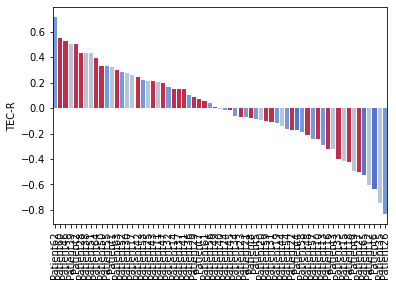

In [25]:
tmp = mean_z_ec_93157.sort_values(by='TEC-R', ascending=False)
sns.barplot(x=tmp.index, y='TEC-R', palette=tmp['response_color'],
            data=tmp)
plt.xticks(rotation=90)
plt.show()

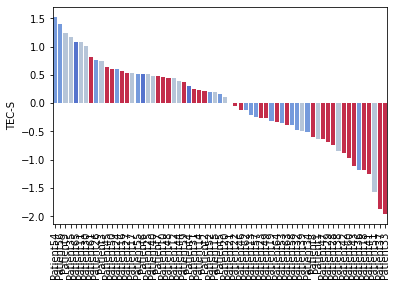

In [79]:
tmp = mean_z_ec_93157.sort_values(by='TEC-S', ascending=False)
sns.barplot(x=tmp.index, y='TEC-S', palette=tmp['response_color'],
            data=tmp)
plt.xticks(rotation=90)
plt.show()

In [27]:
table = mean_z_ec_93157.copy()
table = table.rename(columns={'TEC-S': 'S_mean',
                              'TEC-R': 'R_mean',
                              'R-S': 'R_mean - S_mean'})
table.to_csv('/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/Tables/TableS1/GSE93157_RS_value.csv', sep=',')

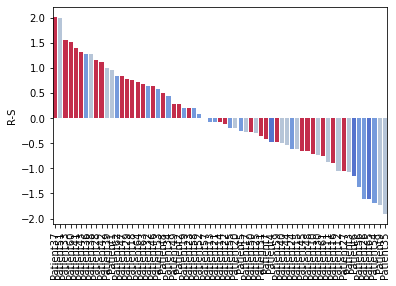

In [81]:
tmp = mean_z_ec_93157.sort_values(by='R-S', ascending=False)
sns.barplot(x=tmp.index, y='R-S', palette=tmp['response_color'],
            data=tmp)
plt.xticks(rotation=90)
fig = plt.gcf()
fig.savefig(auc_home + 'waterfall_93157.pdf', transparent=True)
fig.savefig(auc_home + 'waterfall_93157.png', dpi=300, transparent=True)

In [45]:
mean_z_ec_93157['response_binary'] = 0
for p in mean_z_ec_93157.index:
    if mean_z_ec_93157.loc[p, 'response_color'] in ['crimson']:
        mean_z_ec_93157.at[p, 'response_binary'] = 1

0.6657088122605364


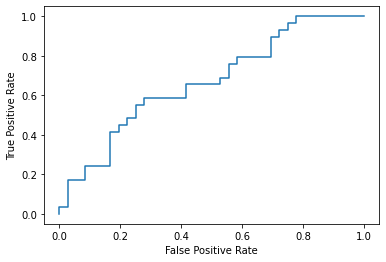

In [46]:
fpr_rs, tpr_rs, _ = roc_curve(mean_z_ec_93157['response_binary'], mean_z_ec_93157['R-S'], pos_label=1)
RocCurveDisplay(fpr=fpr_rs, tpr=tpr_rs).plot()
print(auc(fpr_rs, tpr_rs))

HEADNECK
0.75
LUNG NON-SQUAMOUS CANCER
0.6581196581196581
SQUAMOUS LUNG CANCER
0.75
MELANOMA
0.6558441558441559


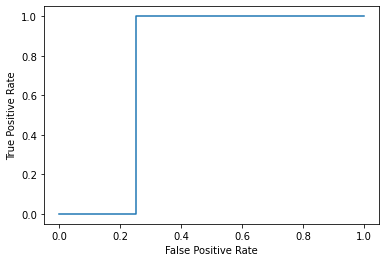

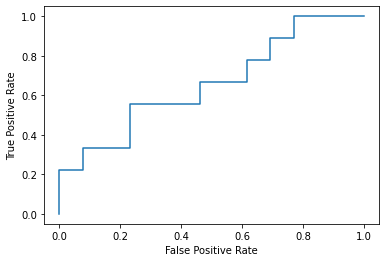

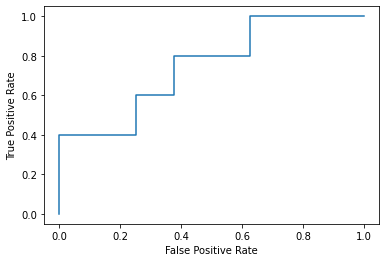

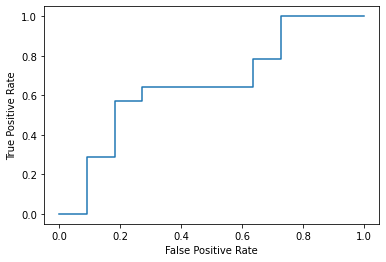

In [47]:
for ct in mean_z_ec_93157['cancer'].unique():
    print(ct)
    tmp = mean_z_ec_93157[mean_z_ec_93157['cancer'] == ct]
    fpr_tmp, tpr_tmp, _ = roc_curve(tmp['response_binary'], tmp['R-S'], pos_label=1)
    RocCurveDisplay(fpr=fpr_tmp, tpr=tpr_tmp).plot()
    print(auc(fpr_tmp, tpr_tmp))

HEADNECK
LUNG NON-SQUAMOUS CANCER
SQUAMOUS LUNG CANCER
MELANOMA


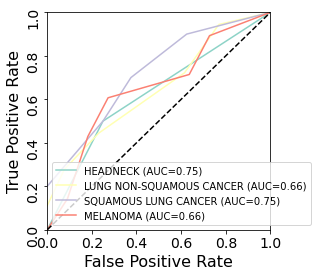

In [56]:
plt.figure(figsize=(4, 4))
sns.set_palette('Set3')
for ct in mean_z_ec_93157['cancer'].unique():
    print(ct)
    tmp = mean_z_ec_93157[mean_z_ec_93157['cancer'] == ct]
    fpr_tmp, tpr_tmp, _ = roc_curve(tmp['response_binary'], tmp['R-S'], pos_label=1)

    # add ROCs
    fpr_tmp, tpr_tmp, _ = roc_curve(tmp['response_binary'], tmp['R-S'], pos_label=1)
    g = sns.lineplot(x=fpr_tmp,
                     y=tpr_tmp,
                     ci=None,
                     label=ct + ' (AUC=' + str(np.round(auc(fpr_tmp, tpr_tmp), 2)) + ')')


# add x=y
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, '--k')

# add labels
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.yticks(rotation=90, fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.xlim(0, 1)
plt.ylim(0, 1)
# plt.tight_layout()
fig = plt.gcf()
fig.savefig(auc_home + 'AUC_93157.pdf', transparent=True)
fig.savefig(auc_home + 'AUC_93157.png', dpi=300, transparent=True)

In [58]:
auc_merged = df(columns=['AUC'])
for ct in mean_z_ec_93157['cancer'].unique():
    tmp = mean_z_ec_93157[mean_z_ec_93157['cancer'] == ct]
    fpr_tmp, tpr_tmp, _ = roc_curve(tmp['response_binary'], tmp['R-S'], pos_label=1)
    auc_merged.at[ct, 'AUC'] = auc(fpr_tmp, tpr_tmp)
auc_merged.at['original', 'AUC'] = 0.78

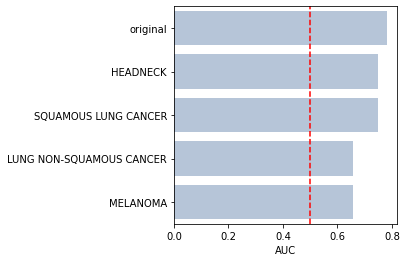

In [71]:
plt.figure(figsize=(4, 4))
auc_merged = auc_merged.sort_values(by='AUC', ascending=False)
sns.barplot(y=auc_merged.index, x=auc_merged['AUC'], color='lightsteelblue')
plt.axvline(x=.5, ls='--', c='red')
fig = plt.gcf()
fig.savefig(auc_home + 'AUC_93157_bar_merged.pdf', transparent=True)
fig.savefig(auc_home + 'AUC_93157_bar_merged.png', dpi=300, transparent=True)

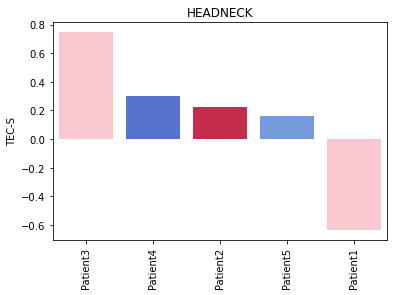

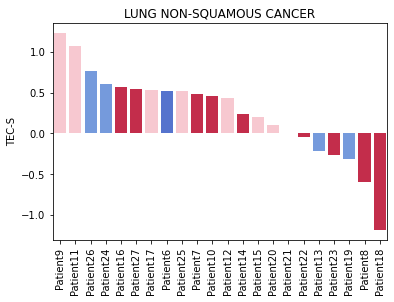

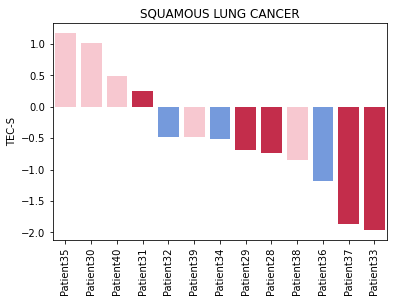

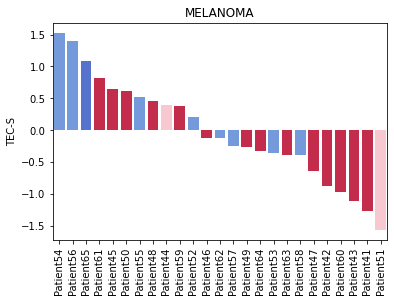

In [33]:
for ct in mean_z_ec_93157['cancer'].unique():
    tmp = mean_z_ec_93157[mean_z_ec_93157['cancer'] == ct]
    tmp = tmp.sort_values(by='TEC-S', ascending=False)
    sns.barplot(x=tmp.index, y='TEC-S', palette=tmp['response_color'],
                data=tmp)
    plt.xticks(rotation=90)
    plt.title(ct)
    plt.show()

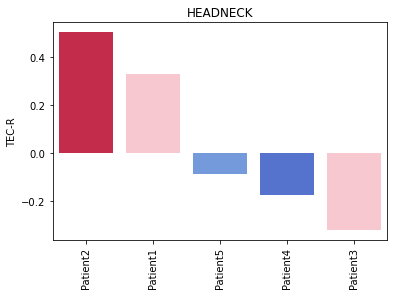

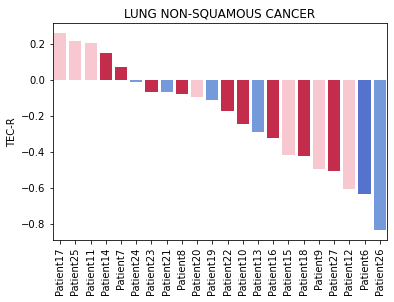

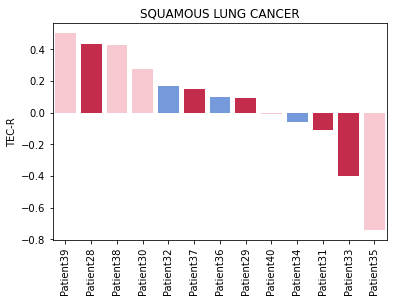

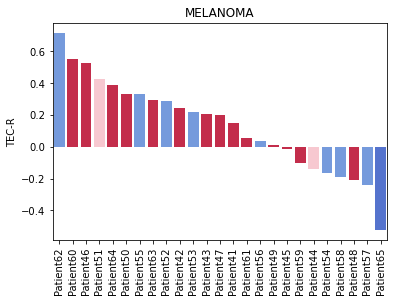

In [32]:
for ct in mean_z_ec_93157['cancer'].unique():
    tmp = mean_z_ec_93157[mean_z_ec_93157['cancer'] == ct]
    tmp = tmp.sort_values(by='TEC-R', ascending=False)
    sns.barplot(x=tmp.index, y='TEC-R', palette=tmp['response_color'],
                data=tmp)
    plt.xticks(rotation=90)
    plt.title(ct)
    plt.show()

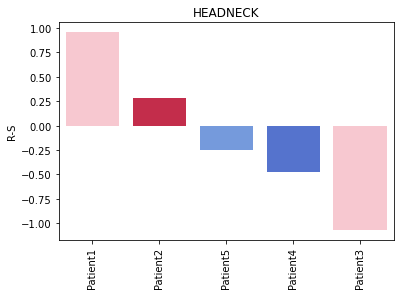

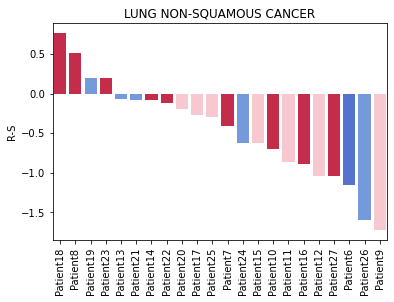

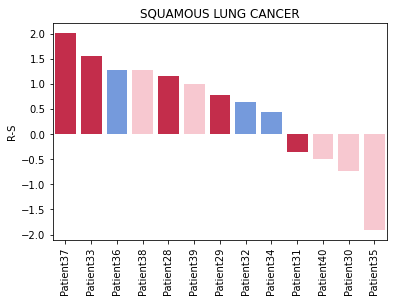

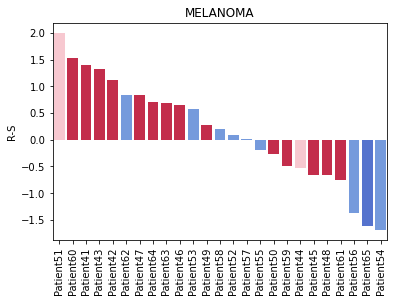

In [31]:
for ct in mean_z_ec_93157['cancer'].unique():
    tmp = mean_z_ec_93157[mean_z_ec_93157['cancer'] == ct]
    tmp = tmp.sort_values(by='R-S', ascending=False)
    sns.barplot(x=tmp.index, y='R-S', palette=tmp['response_color'],
                data=tmp)
    plt.xticks(rotation=90)
    plt.title(ct)
    plt.show()

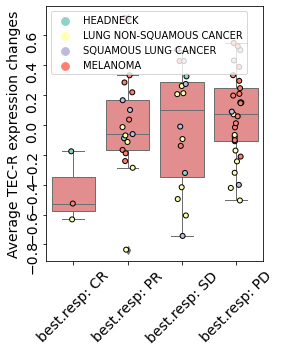

In [73]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='response', y='TEC-R', data=mean_z_ec_93157, color='lightcoral',
            linewidth=1,
            order=['best.resp: CR', 'best.resp: PR', 'best.resp: SD', 'best.resp: PD'])
sns.stripplot(x='response', y='TEC-R', hue='cancer', data=mean_z_ec_93157, palette='Set3',
              edgecolor='k', linewidth=1,
            order=['best.resp: CR', 'best.resp: PR', 'best.resp: SD', 'best.resp: PD'])
plt.xticks(rotation=45, fontsize=14)
plt.xlabel('')
plt.yticks(rotation=90, fontsize=14)
plt.ylabel('Average TEC-R expression changes', fontsize=14)
plt.legend(loc='best')
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/validation/GSE93157_TEC-R_ave.png', transparent=True, dpi=300)
fig.savefig(panel_home + '/validation/GSE93157_TEC-R_ave.pdf', transparent=True)

In [91]:
stats.f_oneway(mean_z_ec_93157[mean_z_ec_93157['response'] == 'best.resp: CR'][['TEC-S', 'TEC-R']],
               mean_z_ec_93157[mean_z_ec_93157['response'] == 'best.resp: PR'][['TEC-S', 'TEC-R']],
               mean_z_ec_93157[mean_z_ec_93157['response'] == 'best.resp: SD'][['TEC-S', 'TEC-R']],
               mean_z_ec_93157[mean_z_ec_93157['response'] == 'best.resp: PD'][['TEC-S', 'TEC-R']])

F_onewayResult(statistic=array([2.70059264, 2.14853595]), pvalue=array([0.05338616, 0.10331979]))

In [93]:
stats.ttest_ind(mean_z_ec_93157[mean_z_ec_93157['response'] == 'best.resp: CR']['TEC-S'],
                mean_z_ec_93157[mean_z_ec_93157['response'] == 'best.resp: PD']['TEC-S'])

Ttest_indResult(statistic=1.9803070930651425, pvalue=0.056904804857852896)

In [94]:
stats.ttest_ind(mean_z_ec_93157[mean_z_ec_93157['response'] == 'best.resp: CR']['TEC-R'],
                mean_z_ec_93157[mean_z_ec_93157['response'] == 'best.resp: PD']['TEC-R'])

Ttest_indResult(statistic=-2.894317569469933, pvalue=0.007018139013951735)

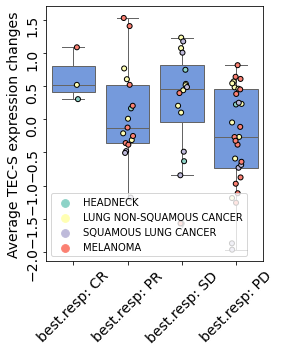

In [74]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='response', y='TEC-S', data=mean_z_ec_93157, color='cornflowerblue',
            linewidth=1,
            order=['best.resp: CR', 'best.resp: PR', 'best.resp: SD', 'best.resp: PD'])
sns.stripplot(x='response', y='TEC-S', hue='cancer', data=mean_z_ec_93157, palette='Set3',
              edgecolor='k', linewidth=1,
            order=['best.resp: CR', 'best.resp: PR', 'best.resp: SD', 'best.resp: PD'])
plt.xticks(rotation=45, fontsize=14)
plt.xlabel('')
plt.yticks(rotation=90, fontsize=14)
plt.ylabel('Average TEC-S expression changes', fontsize=14)
plt.legend(loc='best')
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/validation/GSE93157_TEC-S_ave.png', transparent=True, dpi=300)
fig.savefig(panel_home + '/validation/GSE93157_TEC-S_ave.pdf', transparent=True)

<AxesSubplot:xlabel='TEC-R', ylabel='TEC-S'>

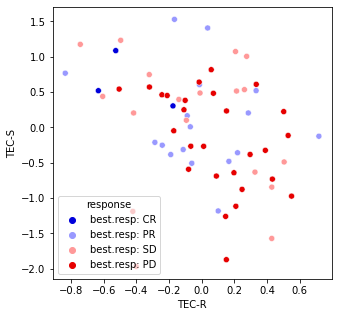

In [75]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='TEC-R', y='TEC-S', data=mean_z_ec_93157,
                hue_order=['best.resp: CR', 'best.resp: PR', 'best.resp: SD', 'best.resp: PD'],
                hue='response', palette='seismic')

In [21]:
mean_ec_93157 = df(index=expr_93157.columns, columns=['NREC', 'REC'])
for p in mean_ec_93157.index:
    mean_ec_93157.at[p, 'NREC'] = nrec_93157[p].mean()
    mean_ec_93157.at[p, 'REC'] = rec_93157[p].mean()

In [22]:
mean_ec_93157

,NREC,REC
Patient1,9.9855,7.30963
Patient2,10.1066,8.27594
Patient3,9.47924,8.81351
Patient4,9.58024,8.49925
Patient5,9.60989,8.23588
...,...,...
Patient61,9.91651,9.03244
Patient62,10.4532,7.7699
Patient63,10.0084,7.63747
Patient64,10.172,7.65033


In [23]:
mean_ec_93157['cancer'] = info_93157['Cancer_type']

In [33]:
mean_ec_93157['response'] = info_93157['Best_Response']

In [34]:
mean_ec_93157

,NREC,REC,cancer,response
Patient1,9.9855,7.30963,HEADNECK,best.resp: SD
Patient2,10.1066,8.27594,HEADNECK,best.resp: PD
Patient3,9.47924,8.81351,HEADNECK,best.resp: SD
Patient4,9.58024,8.49925,HEADNECK,best.resp: CR
Patient5,9.60989,8.23588,HEADNECK,best.resp: PR
...,...,...,...,...
Patient61,9.91651,9.03244,MELANOMA,best.resp: PD
Patient62,10.4532,7.7699,MELANOMA,best.resp: PR
Patient63,10.0084,7.63747,MELANOMA,best.resp: PD
Patient64,10.172,7.65033,MELANOMA,best.resp: PD


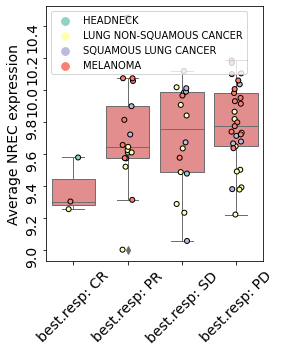

In [84]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='response', y='NREC', data=mean_ec_93157, color='lightcoral',
            linewidth=1,
            order=['best.resp: CR', 'best.resp: PR', 'best.resp: SD', 'best.resp: PD'])
sns.stripplot(x='response', y='NREC', hue='cancer', data=mean_ec_93157, palette='Set3',
              edgecolor='k', linewidth=1,
            order=['best.resp: CR', 'best.resp: PR', 'best.resp: SD', 'best.resp: PD'])
plt.xticks(rotation=45, fontsize=14)
plt.xlabel('')
plt.yticks(rotation=90, fontsize=14)
plt.ylabel('Average NREC expression', fontsize=14)
plt.legend(loc='best')
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/validation/GSE93157_ave_NREC.png', transparent=True, dpi=300)
fig.savefig(panel_home + '/validation/GSE93157_ave_NREC.pdf', transparent=True)

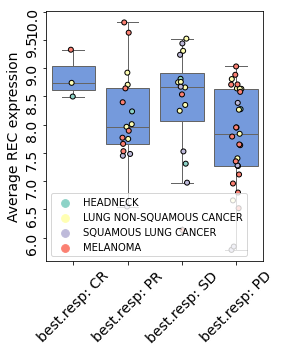

In [87]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='response', y='REC', data=mean_ec_93157, color='cornflowerblue',
            linewidth=1,
            order=['best.resp: CR', 'best.resp: PR', 'best.resp: SD', 'best.resp: PD'])
sns.stripplot(x='response', y='REC', hue='cancer', data=mean_ec_93157, palette='Set3',
              edgecolor='k', linewidth=1,
            order=['best.resp: CR', 'best.resp: PR', 'best.resp: SD', 'best.resp: PD'])
plt.xticks(rotation=45, fontsize=14)
plt.xlabel('')
plt.yticks(rotation=90, fontsize=14)
plt.ylabel('Average REC expression', fontsize=14)
plt.legend(loc='best')
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/validation/GSE93157_ave_REC.png', transparent=True, dpi=300)
fig.savefig(panel_home + '/validation/GSE93157_ave_REC.pdf', transparent=True)

In [19]:
ec_color = df(index=ec_93157.index, columns=['color'])
ec_color.loc[nrec_93157.index, 'color'] = 'crimson'
ec_color.loc[rec_93157.index, 'color'] = 'cornflowerblue'

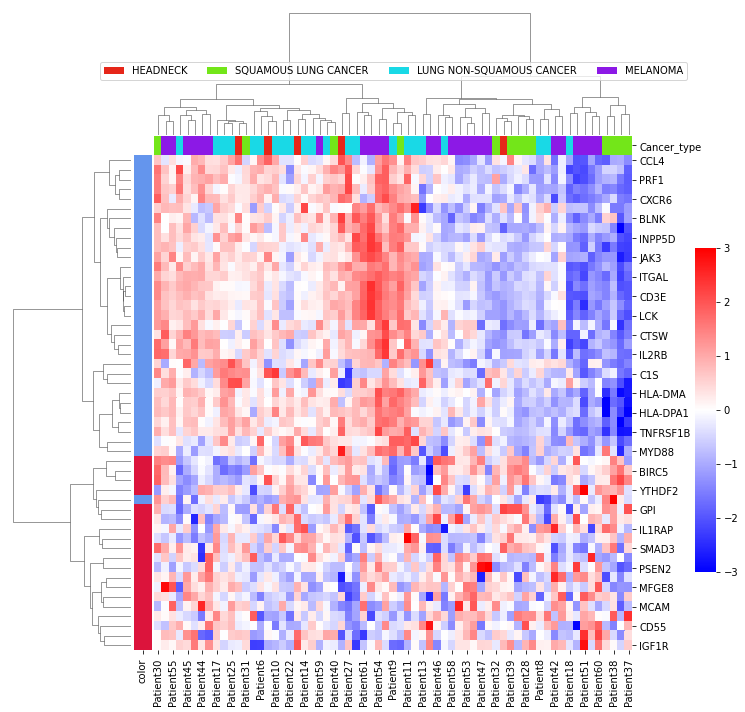

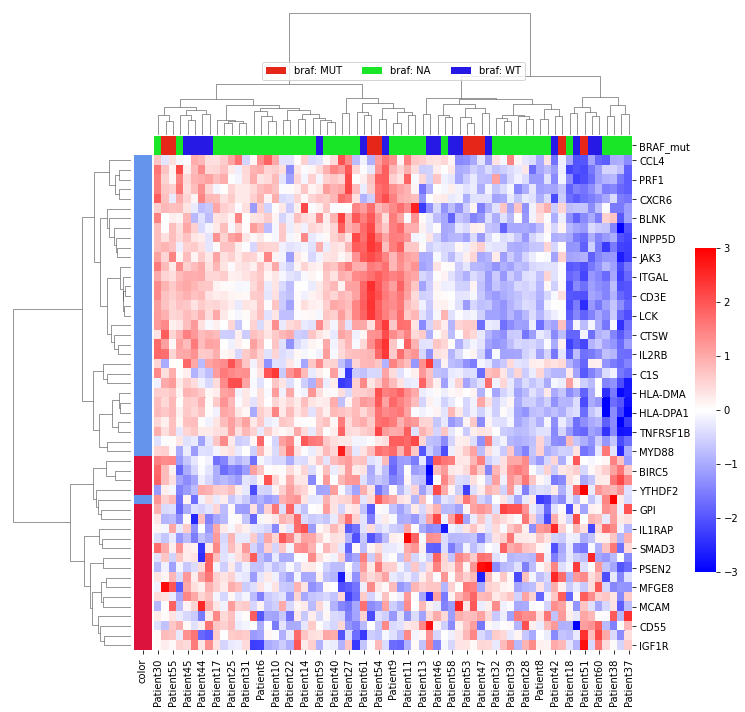

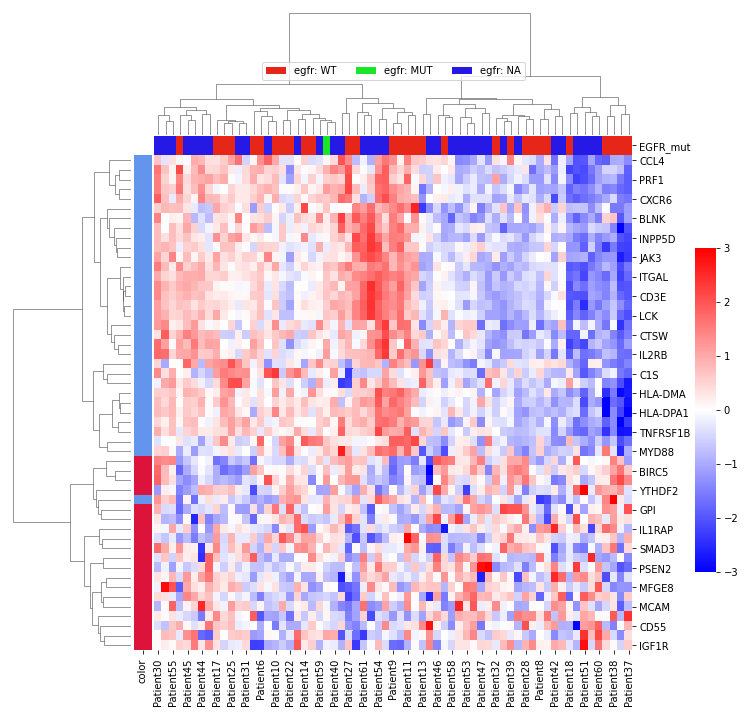

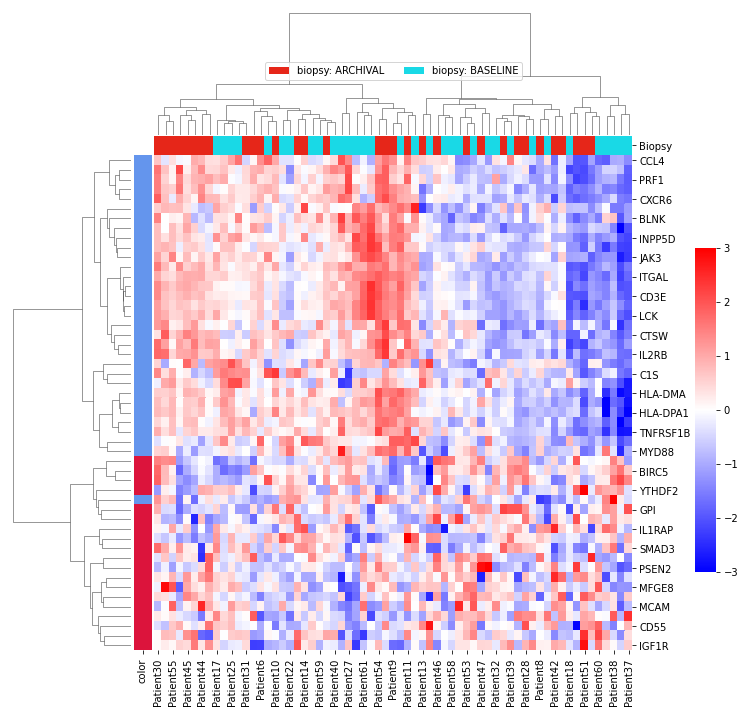

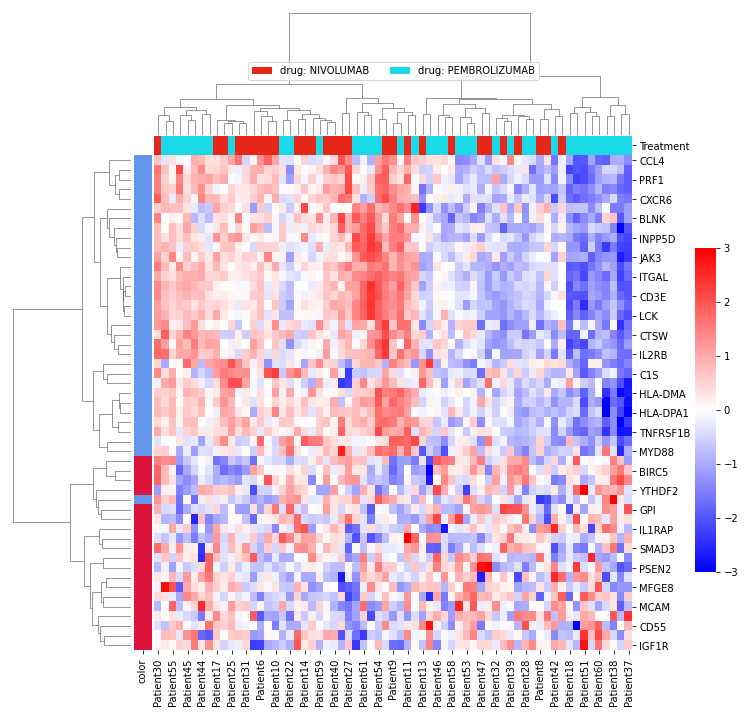

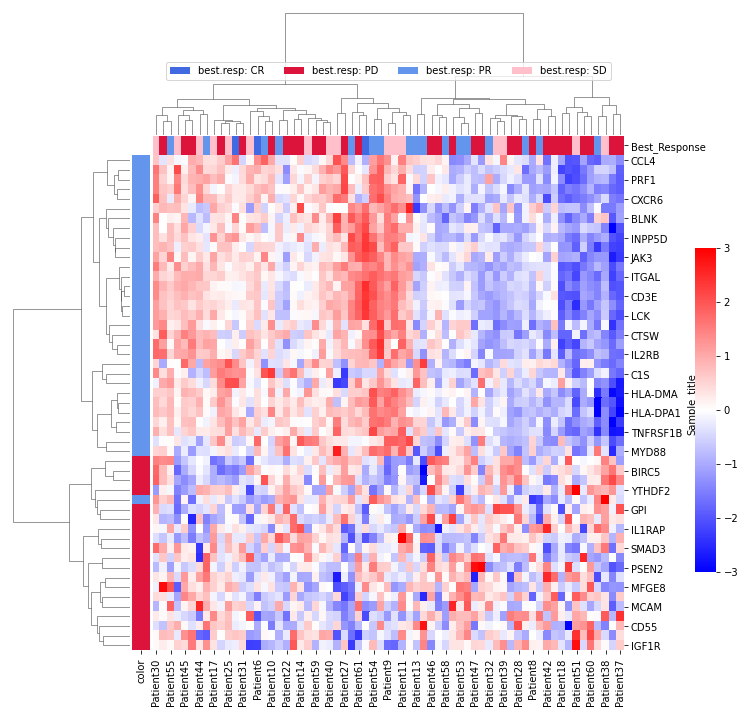

In [20]:
for c in paired_lut.keys():
    g = sns.clustermap(ec_93157[ec_93157 > 0].dropna(axis=0, how='all').fillna(0),
                   vmin=-3, vmax=3, z_score=0,
                   col_colors=paired_lut[c]['color'], row_colors=ec_color['color'],
                   method='ward', cmap='bwr')
    for label in paired_lut[c]['lut'].keys():
        g.ax_col_dendrogram.bar(0, 0, color=paired_lut[c]['lut'][label],
                                label=label, linewidth=0)
        g.ax_col_dendrogram.legend(loc="center", ncol=5)

        # Adjust the postion of the main colorbar for the heatmap
        g.cax.set_position([.97, .2, .03, .45])
    plt.show()